In [8]:
import numpy as np
import matplotlib.pyplot as plt
import equinox as eqx
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

## 1. Génération du Dataset - Problème Laplacien Paramétrique 1D

Nous résolvons l'équation de Poisson 1D avec différentes conditions aux limites:
$$-\frac{d^2 u}{dx^2} = f(x,\mu) \text{ dans } \Omega = [0,1]$$
$$u(0) = g_1(\mu), \quad u(1) = g_2(\mu)$$

où $\mu$ est un paramètre qui contrôle la source et les conditions aux limites.

In [9]:
def generate_laplacian_dataset_1d(n_samples=1000, grid_size=64):
    """
    Génère un dataset de solutions du problème Laplacien paramétrique 1D
    """
    # Grille spatiale 1D
    h = 1.0 / (grid_size - 1)
    x = np.linspace(0, 1, grid_size)
    
    # Matrice Laplacienne 1D (différences finies)
    def build_laplacian_matrix_1d(n):
        h2 = h**2
        # Laplacien 1D: -d²u/dx² ≈ (u[i-1] - 2*u[i] + u[i+1])/h²
        diag_main = -2 * np.ones(n) / h2
        diag_off = np.ones(n-1) / h2
        
        L = diags([diag_off, diag_main, diag_off], [-1, 0, 1], shape=(n, n), format='csc')
        return L
    
    L = build_laplacian_matrix_1d(grid_size)
    solutions = []
    parameters = []
    
    print(f"Génération de {n_samples} solutions 1D...")
    
    for i in range(n_samples):
        # Paramètres aléatoires
        mu1 = np.random.uniform(2.0, 3.0)  # Amplitude source
        mu2 = np.random.uniform(2.0, 6.0)   # Fréquence source
        mu3 = np.random.uniform(0.0, 0.5)  # Condition limite gauche
        mu4 = np.random.uniform(0.0, 0.5)  # Condition limite droite
        
        # Source term f(x, μ)
        f = 10* (mu1 * np.sin(mu2 * np.pi * x) + 0.4 * np.exp(-20*(x-0.5)**2))
        
        # Préparation du terme source
        rhs = -f.copy()
        
        # Application des conditions aux limites u(0) = mu3, u(1) = mu4
        L_modified = L.copy()
        rhs[0] = mu3
        rhs[-1] = mu4
        
        # Modifier la matrice pour imposer les conditions aux limites
        L_modified[0, :] = 0
        L_modified[0, 0] = 1
        L_modified[-1, :] = 0
        L_modified[-1, -1] = 1
        
        # Résolution du système linéaire
        try:
            u = spsolve(L_modified, rhs)
            solutions.append(u)
            parameters.append([mu1, mu2, mu3, mu4])
        except:
            print(f"Erreur résolution échantillon {i}")
            continue
            
        if (i+1) % 200 == 0:
            print(f"  {i+1}/{n_samples} solutions générées")
    
    return np.array(solutions), np.array(parameters), x

# Génération du dataset
solutions, params, x_grid = generate_laplacian_dataset_1d(n_samples=800, grid_size=64)
print(f"Dataset généré: {solutions.shape} solutions")
print(f"Paramètres: {params.shape}")

Génération de 800 solutions 1D...
  200/800 solutions générées


/Users/lyyric/miniconda3/envs/study/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


  400/800 solutions générées
  600/800 solutions générées
  800/800 solutions générées
Dataset généré: (800, 64) solutions
Paramètres: (800, 4)


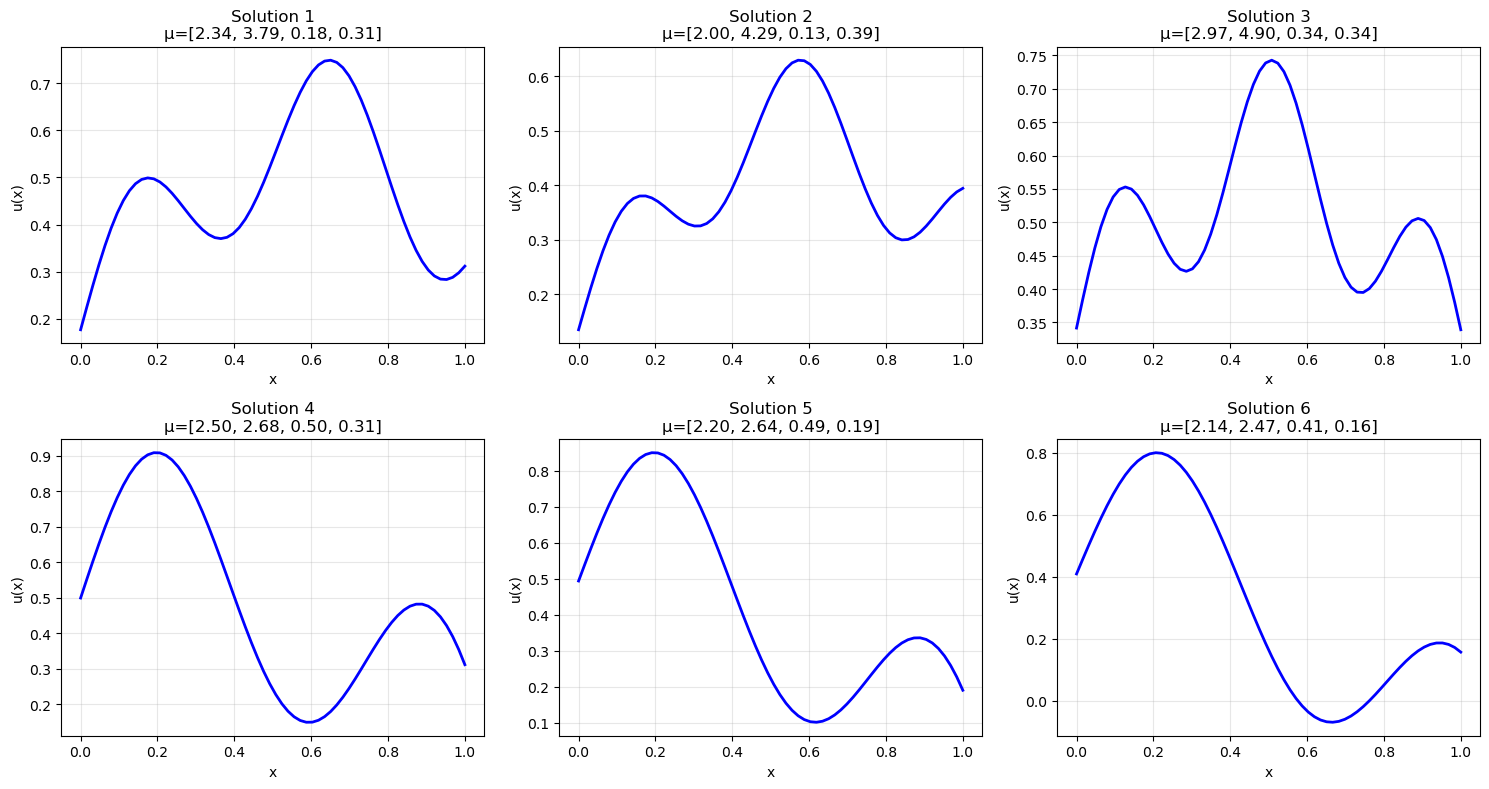

Train: (640, 64), Test: (160, 64)
Normalisation: μ=0.424, σ=0.230


In [10]:
# Visualisation de quelques exemples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].plot(x_grid, solutions[i], 'b-', linewidth=2)
    axes[i].set_title(f'Solution {i+1}\nμ=[{params[i,0]:.2f}, {params[i,1]:.2f}, {params[i,2]:.2f}, {params[i,3]:.2f}]')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('u(x)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Préparation des données
n_train = int(0.8 * len(solutions))
train_data = solutions[:n_train]
test_data = solutions[n_train:]

# Normalisation
mean_val = train_data.mean()
std_val = train_data.std()
train_data_norm = (train_data - mean_val) / std_val
test_data_norm = (test_data - mean_val) / std_val

print(f"Train: {train_data_norm.shape}, Test: {test_data_norm.shape}")
print(f"Normalisation: μ={mean_val:.3f}, σ={std_val:.3f}")

## 2. Convolutional Autoencoder avec JAX/Equinox

Implémentation d'un CAE 1D inspiré de votre architecture PyTorch qui fonctionne bien (Conv1D + Dense).

## 📝 EXERCICE 1: Implémentation du Convolutional Autoencoder

**Objectif:** Implémenter la classe `ConvAutoencoder` avec JAX/Equinox pour la réduction d'ordre de modèles 1D.

### Architecture à implémenter :

#### **Encodeur :**
1. **Partie convolutionnelle :**
   - `conv1`: Conv1d (1 → 32 canaux, kernel=7, stride=2, padding=3)
   - `conv2`: Conv1d (32 → 64 canaux, kernel=7, stride=2, padding=3) 
   - `conv3`: Conv1d (64 → 128 canaux, kernel=7, stride=2, padding=3)
   - Activation ELU après chaque convolution

2. **Partie dense :**
   - Aplatissement (flatten) de la sortie convolutionnelle
   - Séquence de couches linéaires : taille_conv → 512 → 256 → 128 → 64 → `latent_dim`
   - Activation ELU entre chaque couche (sauf la dernière)

#### **Décodeur :**
1. **Partie dense :**
   - Séquence inverse : `latent_dim` → 64 → 128 → 256 → 512 → taille_conv
   - Activation ELU entre chaque couche
   - Reshape vers la forme convolutionnelle

2. **Partie déconvolutionnelle :**
   - `deconv1`: ConvTranspose1d (128 → 64 canaux)
   - `deconv2`: ConvTranspose1d (64 → 32 canaux)
   - `deconv3`: ConvTranspose1d (32 → 1 canal)
   - Activation ELU pour les deux premières, pas d'activation pour la dernière

### Contraintes techniques :
- **Input/Output:** La reconstruction doit avoir exactement la même taille que l'entrée (64 points)
- **Batching:** Utiliser `jax.vmap` pour traiter les batches
- **Calculs automatiques:** Les tailles des couches intermédiaires doivent être calculées automatiquement
- **Flexibilité:** L'architecture doit fonctionner avec différentes tailles de kernel (3, 5, 7, etc.)

### Conseils d'implémentation :
1. **Calcul des tailles :** Implémentez des méthodes helper pour calculer les dimensions après convolutions
2. **Output padding :** Calculez automatiquement les `output_padding` pour les déconvolutions
3. **Gestion des dimensions :** Ajustez les dimensions finales si nécessaire (troncature/padding)
4. **Module Equinox :** Héritez de `eqx.Module` et utilisez les annotations de types


### Test de votre implémentation :
Votre code doit pouvoir :
- Créer un modèle : `model = ConvAutoencoder(input_dim=64, latent_dim=2, key=key)`
- Faire une passe avant : `reconstruction, latent = model(test_batch)`
- Vérifier les dimensions : `assert reconstruction.shape == test_batch.shape`

In [11]:
# À VOUS DE JOUER ! 
# Implémentez la classe ConvAutoencoder ici

class ConvAutoencoder(eqx.Module):
    # Définissez vos attributs ici
    conv1: eqx.nn.Conv1d
    conv2: eqx.nn.Conv1d
    conv3: eqx.nn.Conv1d

    enc_linears: tuple
    dec_linears: tuple

    deconv1: eqx.nn.ConvTranspose1d
    deconv2: eqx.nn.ConvTranspose1d
    deconv3: eqx.nn.ConvTranspose1d

    input_dim: int
    latent_dim: int
    sizes_after_conv: tuple
    output_paddings: tuple

    def _calculate_conv_sizes(self, input_size, kernel_size, padding):
        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size + 2 * padding - kernel_size) // stride + 1

        size1 = conv_output_size(input_size, kernel_size, 2, padding)
        size2 = conv_output_size(size1,       kernel_size, 2, padding)
        size3 = conv_output_size(size2,       kernel_size, 2, padding)
        return (size1, size2, size3)

    def _calculate_output_paddings(self, kernel_size, padding):
        sizes = self.sizes_after_conv

        def needed_output_padding(target, input_s, kernel, stride, padding):
            expected = (input_s - 1) * stride - 2 * padding + kernel
            return max(0, target - expected)

        out_pad1 = needed_output_padding(sizes[1], sizes[2], kernel_size, 2, padding)
        out_pad2 = needed_output_padding(sizes[0], sizes[1], kernel_size, 2, padding)
        out_pad3 = needed_output_padding(self.input_dim, sizes[0], kernel_size, 2, padding)

        return (out_pad1, out_pad2, out_pad3)
    
    def __init__(self, input_dim, latent_dim, key):
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        kernel_size = 7
        padding = 3

        self.sizes_after_conv = self._calculate_conv_sizes(input_dim, kernel_size, padding)
        s1, s2, s3 = self.sizes_after_conv

        self.output_paddings = self._calculate_output_paddings(kernel_size, padding)
        op1, op2, op3 = self.output_paddings

        flatten_dim = 128 * s3

        keys = jr.split(key, 16)
        
        self.conv1 = eqx.nn.Conv1d(1, 32, kernel_size, stride=2, padding=padding, key=keys[0])
        self.conv2 = eqx.nn.Conv1d(32, 64, kernel_size, stride=2, padding=padding, key=keys[1])
        self.conv3 = eqx.nn.Conv1d(64,128, kernel_size, stride=2, padding=padding, key=keys[2])

        self.enc_linears = (
            eqx.nn.Linear(flatten_dim, 512, key=keys[3]),
            eqx.nn.Linear(512, 256, key=keys[4]),
            eqx.nn.Linear(256, 128, key=keys[5]),
            eqx.nn.Linear(128, 64,  key=keys[6]),
            eqx.nn.Linear(64, latent_dim, key=keys[7]),
        )

        self.dec_linears = (
            eqx.nn.Linear(latent_dim, 64,    key=keys[8]),
            eqx.nn.Linear(64,        128,   key=keys[9]),
            eqx.nn.Linear(128,       256,   key=keys[10]),
            eqx.nn.Linear(256,       512,   key=keys[11]),
            eqx.nn.Linear(512,       flatten_dim, key=keys[12]),
        )

        self.deconv1 = eqx.nn.ConvTranspose1d(128, 64, kernel_size, stride=2, padding=padding, output_padding=op1, key=keys[13])
        self.deconv2 = eqx.nn.ConvTranspose1d(64, 32, kernel_size, stride=2, padding=padding, output_padding=op2, key=keys[14])
        self.deconv3 = eqx.nn.ConvTranspose1d(32, 1, kernel_size, stride=2, padding=padding, output_padding=op3, key=keys[15])
    
    def encode(self, x):
        h = x[None, :]
        h = jax.nn.elu(self.conv1(h))
        h = jax.nn.elu(self.conv2(h))
        h = jax.nn.elu(self.conv3(h))
        h = h.reshape(-1)
        for layer in self.enc_linears[:-1]:
            h = jax.nn.elu(layer(h))
        return self.enc_linears[-1](h)
    
    def decode(self, latent):
        h = latent
        for layer in self.dec_linears[:-1]:
            h = jax.nn.elu(layer(h))
        h = self.dec_linears[-1](h)
        h = h.reshape(128, self.sizes_after_conv[2])
        h = jax.nn.elu(self.deconv1(h))
        h = jax.nn.elu(self.deconv2(h))
        h = self.deconv3(h)
        return h[0]
    
    def __call__(self, x):
        encoded_vm = jax.vmap(self.encode)
        decoded_vm = jax.vmap(self.decode)
        latent = encoded_vm(x)
        recon = decoded_vm(latent)
        return recon, latent

# Fonctions d'entraînement à implémenter
@eqx.filter_jit
def compute_loss(model, x):
    reconstruction, _ = model(x)
    return jnp.mean((reconstruction - x)**2)

def train_step(model, opt_state, optimizer, x):
    loss, grads = eqx.filter_value_and_grad(compute_loss)(model, x)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

@eqx.filter_jit
def eval_model(model, x):
    reconstruction, latent = model(x)
    loss = jnp.mean((reconstruction - x)**2)
    return loss, reconstruction, latent

In [15]:
def train_autoencoder(train_data, latent_dim, epochs=100, batch_size=128, learning_rate=2e-4):
    """
    Entraîne un autoencoder convolutionnel avec Equinox
    """
    input_dim = train_data.shape[1]  # 64 pour notre grille 1D
    
    # Initialisation du modèle
    key = jr.PRNGKey(42)
    model = ConvAutoencoder(input_dim, latent_dim, key)
    
    # Optimiseur
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    
    # Préparation des données
    n_batches = len(train_data) // batch_size
    train_losses = []
    
    print(f"Entraînement CAE (latent_dim={latent_dim})...")
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Mélanger les données
        perm = np.random.permutation(len(train_data))
        
        for i in range(n_batches):
            batch_idx = perm[i*batch_size:(i+1)*batch_size]
            batch = jnp.array(train_data[batch_idx])
            
            model, opt_state, loss = train_step(model, opt_state, optimizer, batch)
            epoch_loss += loss
        
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"  Époque {epoch+1:3d}: loss = {avg_loss:.6f}")
    
    return model, train_losses

# Entraînement des deux modèles (décommentez après implémentation)
print("=" * 50)
model_latent1, losses_latent1 = train_autoencoder(train_data_norm, latent_dim=2, epochs=1000)
print("=" * 50)
model_latent2, losses_latent2 = train_autoencoder(train_data_norm, latent_dim=3, epochs=1000)

Entraînement CAE (latent_dim=2)...
  Époque   5: loss = 0.617689
  Époque  10: loss = 0.315915
  Époque  15: loss = 0.223117
  Époque  20: loss = 0.200973
  Époque  25: loss = 0.190723
  Époque  30: loss = 0.177032
  Époque  35: loss = 0.156479
  Époque  40: loss = 0.126431
  Époque  45: loss = 0.101423
  Époque  50: loss = 0.088586
  Époque  55: loss = 0.078191
  Époque  60: loss = 0.071230
  Époque  65: loss = 0.067965
  Époque  70: loss = 0.064347
  Époque  75: loss = 0.061826
  Époque  80: loss = 0.059953
  Époque  85: loss = 0.059109
  Époque  90: loss = 0.058958
  Époque  95: loss = 0.058146
  Époque 100: loss = 0.056128
  Époque 105: loss = 0.056041
  Époque 110: loss = 0.054949
  Époque 115: loss = 0.054439
  Époque 120: loss = 0.055088
  Époque 125: loss = 0.054125
  Époque 130: loss = 0.053674
  Époque 135: loss = 0.053183
  Époque 140: loss = 0.053128
  Époque 145: loss = 0.052796
  Époque 150: loss = 0.051655
  Époque 155: loss = 0.051447
  Époque 160: loss = 0.050385
  Épo

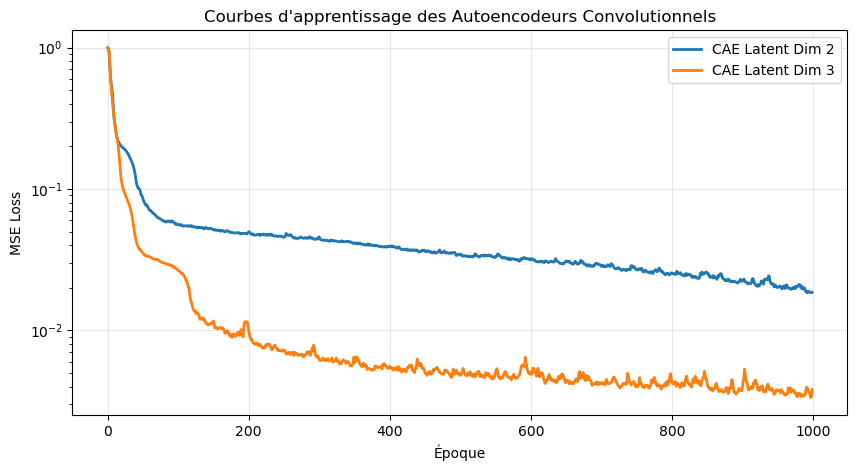

In [16]:
# Visualisation des courbes de perte (décommentez après implémentation)
plt.figure(figsize=(10, 5))
plt.plot(losses_latent1, label='CAE Latent Dim 2', linewidth=2)
plt.plot(losses_latent2, label='CAE Latent Dim 3', linewidth=2)
plt.xlabel('Époque')
plt.ylabel('MSE Loss')
plt.title('Courbes d\'apprentissage des Autoencodeurs Convolutionnels')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## 3. Proper Orthogonal Decomposition (POD)

Implémentation de la POD classique via décomposition en valeurs singulières pour données 1D.

## 📝 EXERCICE 2: Implémentation de la POD (Proper Orthogonal Decomposition)

**Objectif:** Implémenter la classe `PODModel` pour la réduction d'ordre par décomposition orthogonale.

### Principe de la POD :
La POD trouve les modes optimaux pour représenter un dataset en minimisant l'erreur de reconstruction. Elle utilise la décomposition en valeurs singulières (SVD) sur les données centrées.

### Algorithme à implémenter :

#### **Méthode `fit(self, data)` :**
1. **Centrage :** Calculer et stocker la moyenne des données
   - `mean_field = np.mean(data, axis=0)`
   - `data_centered = data - mean_field`

2. **SVD :** Appliquer la décomposition en valeurs singulières
   - `U, s, Vt = np.linalg.svd(data_centered.T, full_matrices=False)`
   - Stocker les modes (`U`), valeurs singulières (`s`)

3. **Énergie :** Calculer l'énergie cumulée
   - `energy = s**2`
   - `cumulative_energy = np.cumsum(energy) / np.sum(energy)`

#### **Méthode `reconstruct(self, data, n_modes_reconstruct)` :**
1. **Centrage :** Centrer les données avec la moyenne calculée
2. **Projection :** Projeter sur les `n_modes_reconstruct` premiers modes
   - `coefficients = modes_truncated.T @ data_centered.T`
3. **Reconstruction :** Reconstruire et ajouter la moyenne
   - `reconstructed = (modes_truncated @ coefficients).T + mean_field`

### Attributs de la classe :
- `mean_field`: Champ moyen des données d'entraînement
- `modes`: Modes POD (vecteurs propres, matrice U de la SVD)
- `singular_values`: Valeurs singulières
- `n_modes`: Nombre total de modes disponibles

### Contraintes :
- Les données sont de forme `(n_samples, n_points)`
- La reconstruction doit préserver exactement la forme des données d'entrée
- Gérer le cas où `n_modes_reconstruct > n_modes` disponibles

### Validation :
Votre implémentation doit :
- Calculer l'énergie cumulée correctement
- Reconstruire parfaitement avec tous les modes
- Donner des erreurs décroissantes avec plus de modes

In [18]:
# À VOUS DE JOUER !
# Implémentez la classe PODModel ici

class PODModel:
    def __init__(self):
        # Initialisez vos attributs ici
        self.mean_field = None
        self.modes = None
        self.singular_values = None
        self.n_modes = None
    
    def fit(self, data):
        """
        Calcule les modes POD via SVD pour données 1D
        data: (n_samples, n_points)
        """
        self.mean_field = np.mean(data, axis=0)
        X = data - self.mean_field
        U, s, Vt = np.linalg.svd(X.T, full_matrices=False)
        self.modes = U
        self.singular_values = s
        self.n_modes = len(s)
        return np.cumsum(s**2) / np.sum(s**2)
    
    def reconstruct(self, data, n_modes_reconstruct):
        """
        Reconstruit avec un nombre donné de modes pour données 1D
        """
        passn_modes = min(n_modes_reconstruct, self.n_modes)
        X = data - self.mean_field
        Ur = self.modes[:, :n_modes_reconstruct]
        coeff = Ur.T @ X.T
        return (Ur @ coeff).T + self.mean_field

# Calcul de la POD (décommentez après implémentation)
pod_model = PODModel()
cumulative_energy = pod_model.fit(train_data_norm)

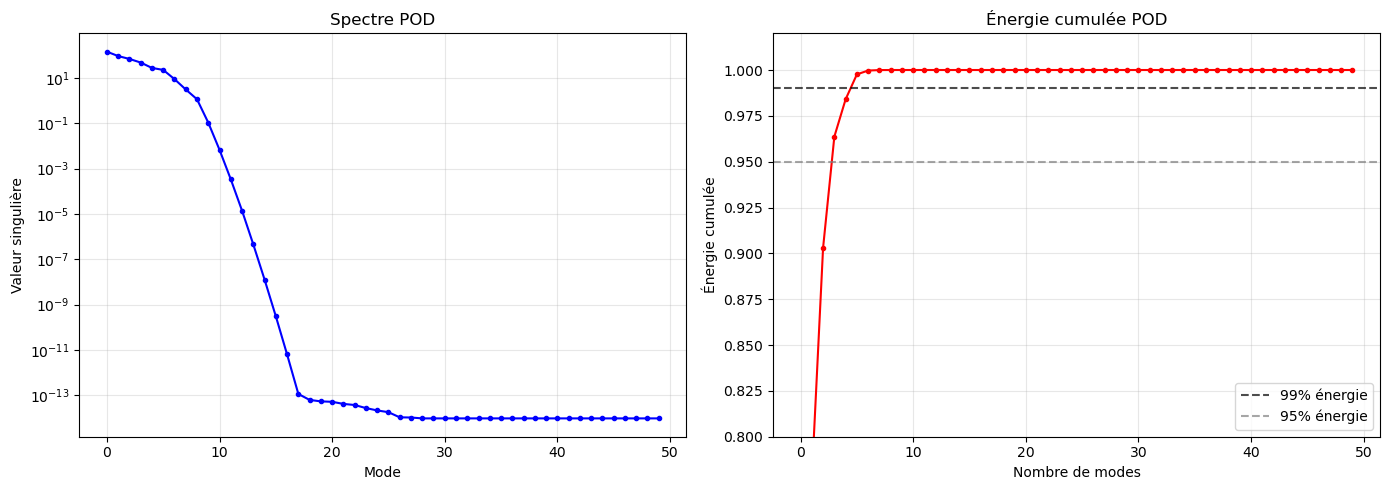

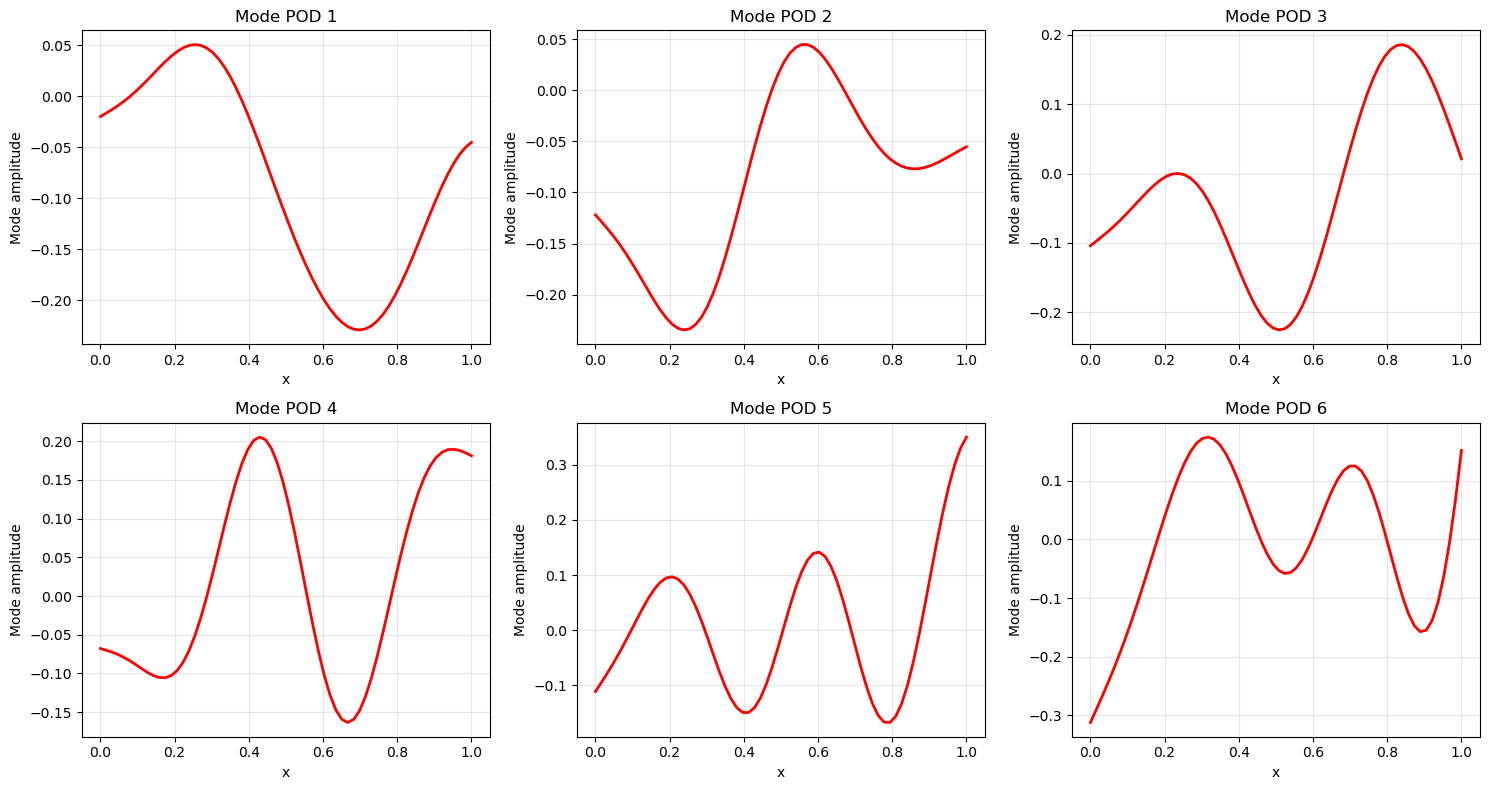

In [19]:
# Visualisation du spectre POD (décommentez après implémentation)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Valeurs singulières
ax1.semilogy(pod_model.singular_values[:50], 'bo-', markersize=3)
ax1.set_xlabel('Mode')
ax1.set_ylabel('Valeur singulière')
ax1.set_title('Spectre POD')
ax1.grid(True, alpha=0.3)

# Énergie cumulée
ax2.plot(cumulative_energy[:50], 'ro-', markersize=3)
ax2.axhline(y=0.99, color='k', linestyle='--', alpha=0.7, label='99% énergie')
ax2.axhline(y=0.95, color='gray', linestyle='--', alpha=0.7, label='95% énergie')
ax2.set_xlabel('Nombre de modes')
ax2.set_ylabel('Énergie cumulée')
ax2.set_title('Énergie cumulée POD')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim([0.8, 1.02])

plt.tight_layout()
plt.show()

# Affichage de quelques modes POD
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    mode = pod_model.modes[:, i]
    axes[i].plot(x_grid, mode, 'r-', linewidth=2)
    axes[i].set_title(f'Mode POD {i+1}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Mode amplitude')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Comparaison des Reconstructions

Comparons les performances de reconstruction entre AE et POD sur des exemples de test.

## 🎯 Analyse et Comparaison

Une fois vos implémentations terminées, décommentez les cellules suivantes pour :

1. **Entraîner les modèles** avec différentes dimensions latentes
2. **Comparer les reconstructions** sur les données de test
3. **Analyser les performances** via des métriques et visualisations
4. **Étudier l'espace latent** des autoencodeurs

### Questions de réflexion :
- Quelle méthode donne les meilleures reconstructions ?
- Comment évolue la qualité avec le nombre de modes/dimension latente ?
- Quels sont les avantages/inconvénients de chaque approche ?
- L'espace latent des CAE capture-t-il bien la variabilité des données ?

In [20]:
# Sélection d'exemples de test (décommentez après implémentation)
test_indices = [0, 5, 10, 15, 20, 25]  # 6 exemples
test_samples = test_data_norm[test_indices]

# Reconstructions CAE avec Equinox
print("Reconstruction avec les CAE...")
_, recon_cae_latent1, latent1 = eval_model(model_latent1, jnp.array(test_samples))
_, recon_cae_latent2, latent2 = eval_model(model_latent2, jnp.array(test_samples))

recon_cae_latent1 = np.array(recon_cae_latent1)
recon_cae_latent2 = np.array(recon_cae_latent2)
latent1 = np.array(latent1)
latent2 = np.array(latent2)

# Reconstructions POD
print("Reconstruction avec POD...")
pod_modes = [2, 4, 6, 10]
recon_pod = {}

for n_modes in pod_modes:
    recon_pod[n_modes] = pod_model.reconstruct(test_samples, n_modes)

print("Reconstructions terminées!")

Reconstruction avec les CAE...
Reconstruction avec POD...
Reconstructions terminées!


In [21]:
# Calcul des erreurs de reconstruction pour données 1D (décommentez après implémentation)
def compute_reconstruction_error(original, reconstructed):
    return np.mean((original - reconstructed)**2, axis=1)

# Erreurs pour tous les exemples de test
errors_cae_latent1 = compute_reconstruction_error(test_samples, recon_cae_latent1)
errors_cae_latent2 = compute_reconstruction_error(test_samples, recon_cae_latent2)

errors_pod = {}
for n_modes in pod_modes:
    errors_pod[n_modes] = compute_reconstruction_error(test_samples, recon_pod[n_modes])

# Statistiques des erreurs
print("Erreurs moyennes de reconstruction (MSE):")
print(f"CAE Latent 2D: {np.mean(errors_cae_latent1):.6f} ± {np.std(errors_cae_latent1):.6f}")
print(f"CAE Latent 3D: {np.mean(errors_cae_latent2):.6f} ± {np.std(errors_cae_latent2):.6f}")
for n_modes in pod_modes:
    print(f"POD {n_modes:2d} modes: {np.mean(errors_pod[n_modes]):.6f} ± {np.std(errors_pod[n_modes]):.6f}")

Erreurs moyennes de reconstruction (MSE):
CAE Latent 2D: 0.060389 ± 0.039851
CAE Latent 3D: 0.049204 ± 0.088205
POD  2 modes: 0.144527 ± 0.034451
POD  4 modes: 0.024309 ± 0.011660
POD  6 modes: 0.002275 ± 0.001311
POD 10 modes: 0.000000 ± 0.000000
